# **<span style="color:blue">Desafío 3 - Enfermedad en la sangre</span>**

### **<span style="color:orange">Punto 1.- Importación de librerías, carga y análisis exploratorio de datos</span>**

In [55]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y división de datos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb

# Selección de hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Cargar los datos
file_path = r"C:\Users\atapi\Documents\DATA SCIENCE\Modulo 6- Redes neuronales\Modelos de ensamble III\Desafio 3\hcvdat0.csv"
df = pd.read_csv(file_path)

# Mostrar las primeras filas para revisar la estructura de los datos
df.head()


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [23]:
# 1. Eliminar la columna 'Unnamed: 0' (índice duplicado)
# Esta columna no aporta información relevante, ya que es solo un índice repetido.
df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Codificar la variable objetivo 'Category'
# Se crea una nueva columna 'target', que será la variable que el modelo intentará predecir.
# Si la categoría es '0=Blood Donor' (donante sano), se asigna 0.
# Para todas las demás categorías (posibles enfermedades hepáticas), se asigna 1.
df['target'] = np.where(df['Category'] == '0=Blood Donor', 0, 1)

# 3. Crear columna 'suspect' (1 si es donante sospechoso, 0 en caso contrario)
# Se crea una variable binaria que indica si el paciente es un donante sospechoso.
# Si la categoría es '0s=suspect Blood Donor', se asigna 1 (sospechoso).
# En caso contrario, se asigna 0.
df['suspect'] = np.where(df['Category'] == '0s=suspect Blood Donor', 1, 0)

# 4. Eliminar la columna 'Category'
# Ya que hemos extraído toda la información relevante de 'Category', podemos eliminarla.
df.drop(columns=['Category'], inplace=True)

# 5. Convertir 'Sex' en variable numérica
# Se codifica la variable 'Sex' en valores numéricos para facilitar su uso en modelos de Machine Learning.
# 'f' (femenino) se convierte en 0 y 'm' (masculino) se convierte en 1.
df['Sex'] = df['Sex'].map({'f': 0, 'm': 1})

# 6. Manejo de valores nulos
# Se calcula la cantidad de valores nulos por columna y su porcentaje sobre el total de filas.
missing_values = df.isnull().sum()  # Número de valores nulos por columna
total_rows = df.shape[0]  # Número total de filas en el dataset
missing_percent = (missing_values / total_rows) * 100  # Porcentaje de valores nulos

# Aplicar reglas para el tratamiento de valores nulos
for column in df.columns:
    if missing_percent[column] > 0:  # Si hay valores nulos en la columna
        if missing_percent[column] < 1:
            # 🔹 Si la columna tiene menos del 1% de valores nulos, eliminamos esas filas.
            df.dropna(subset=[column], inplace=True)
        else:
            # 🔹 Si la columna tiene más del 1% de valores nulos, reemplazamos con la media del grupo 'target'.
            df[column] = df.groupby('target')[column].transform(lambda x: x.fillna(x.mean()))

# 7. Aplicar transformación logarítmica a variables con sesgo positivo
# Se aplica log1p(x) = log(1 + x) a variables que tienen valores extremadamente altos y distribuciones asimétricas.
# Esto ayuda a reducir la asimetría y hacer que los valores sean más comparables.
variables_log = ['ALT', 'AST', 'BIL', 'GGT', 'ALP', 'CREA']
df[variables_log] = df[variables_log].apply(np.log1p)

# 8. Aplicar estandarización (Z-score) a las demás variables
# La estandarización convierte cada variable en una distribución con media 0 y desviación estándar 1.
# Esto permite que todas las variables tengan la misma escala y evita que variables con valores grandes dominen el modelo.
scaler = StandardScaler()
variables_scaling = [col for col in df.columns if col not in ['target', 'suspect']]
df[variables_scaling] = scaler.fit_transform(df[variables_scaling])

# 9. Mostrar el resumen de valores ausentes después del tratamiento
# Se imprime la cantidad de valores nulos en cada columna después del preprocesamiento.
print("Valores nulos después del preprocesamiento:")
print(df.isnull().sum())



Valores nulos después del preprocesamiento:
Age        0
Sex        0
ALB        0
ALP        0
ALT        0
AST        0
BIL        0
CHE        0
CHOL       0
CREA       0
GGT        0
PROT       0
target     0
suspect    0
dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 614
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      612 non-null    float64
 1   Sex      612 non-null    float64
 2   ALB      612 non-null    float64
 3   ALP      612 non-null    float64
 4   ALT      612 non-null    float64
 5   AST      612 non-null    float64
 6   BIL      612 non-null    float64
 7   CHE      612 non-null    float64
 8   CHOL     612 non-null    float64
 9   CREA     612 non-null    float64
 10  GGT      612 non-null    float64
 11  PROT     612 non-null    float64
 12  target   612 non-null    int32  
 13  suspect  612 non-null    int32  
dtypes: float64(12), int32(2)
memory usage: 66.9 KB


#### **<span style="color:purple">Análisis del DataFrame</span>**

**Cantidad de Datos:**

- **Total de registros:** 612  
- **Total de columnas:** 14  
- **No hay valores nulos en ninguna columna**  

**Tipos de Datos:**

- **10 variables numéricas** ('float64'), correspondientes a mediciones clínicas.  
- **3 variables categóricas convertidas en numéricas ('int64' e 'int32')**:
  - **Sex** (0 = femenino, 1 = masculino)  
  - **target** (0 = donante sano, 1 = posible enfermedad hepática)  
  - **suspect** (1 = donante sospechoso, 0 = no sospechoso)  

**Descripción de las Variables:**

| **Variable** | **Descripción** |
|-------------|----------------|
| `Age` | Edad del paciente |
| `Sex` | Género del paciente (`0=femenino`, `1=masculino`) |
| `ALB`, `ALP`, `ALT`, `AST`, `BIL`, `CHE`, `CHOL`, `CREA`, `GGT`, `PROT` | Parámetros bioquímicos relacionados con la función hepática y renal |
| `target` | **Variable objetivo** (`0 = Donante sano`, `1 = Posible enfermedad hepática`) |
| `suspect` | Indica si el donante es sospechoso (`1 = sospechoso`, `0 = no sospechoso`) |

**Uso de Memoria:**

- 66.9 KB de uso, lo que indica que el dataset es pequeño y manejable.

**Tratamiento de Outliers y Transformaciones Aplicadas**
- Antes de generar los gráficos, se analizaron los **valores extremos** en las variables bioquímicas.  
- Las **enzimas hepáticas (ALT, AST, BIL, GGT, ALP, CREA)** suelen presentar **valores anormalmente altos en pacientes con enfermedades hepáticas**.  

---

#### **<span style="color:teal">Análisis de Outliers</span>**

**¿Por qué no eliminamos los outliers?**

1. **Son clínicamente relevantes**  
   - Los valores altos de **ALT, AST, BIL y GGT** pueden ser indicadores de **hepatitis, fibrosis o cirrosis**.  
   - **Eliminar estos valores podría hacer que el modelo no detecte correctamente pacientes enfermos**.  

2. **Los valores extremos pueden representar casos reales**  
   - No son errores en la medición, sino que reflejan **diferencias fisiológicas en pacientes con enfermedad hepática**.  

3. **Eliminar outliers puede distorsionar el dataset**  
   - Si eliminamos valores extremos, **solo quedarán los valores "normales"** de los pacientes sanos.  
   - **Esto puede hacer que el modelo aprenda mal y subestime los casos graves**.


**<span style="color:olive">Solución: Transformación Logarítmica en Variables Sesgadas</span>**

- Dado que muchas variables clínicas tienen **sesgo positivo** (colas largas a la derecha en la distribución), **se aplicó transformación logarítmica ('log1p') en lugar de eliminar los valores extremos**.

- **Variables transformadas:** *ALT*, *AST*, *BIL*, *GGT*, *ALP*, *CREA*  

- **¿Por qué usar 'log1p(x) = log(1 + x)'?**

    - **Reduce el impacto de valores extremadamente altos**, sin alterar la relación entre los datos.  
    - **Hace que las distribuciones sean más simétricas**, mejorando el rendimiento del modelo.  

---

#### **<span style="color:teal">Tratamiento de Valores Nulos</span>**

1. **No hay valores nulos después del preprocesamiento.**  
2. **Reglas aplicadas:**
   - Si una columna tiene **menos del 1% de datos faltantes**, **se eliminan esas filas**.  
   - Si una columna tiene **más del 1% de datos faltantes**, **se reemplazan los valores nulos con la media de su grupo ('target')**.

---

**<span style="color:olive">¿Por qué 'suspect' no es la variable objetivo y 'target' sí?</span>**

- La variable **'target'** es la verdadera **variable objetivo** porque define la clasificación de los pacientes en dos categorías principales:  
    - **0** → Donante de sangre sano (**"0=Blood Donor"**)  
    - **1** → Paciente con posible enfermedad hepática (cualquier otra categoría)

- La variable **'suspect' no es la variable objetivo**, sino una variable auxiliar que indica si un donante es sospechoso o no.


- **Diferencias clave entre 'target' y 'suspect'**

| Variable   | Tipo de Clasificación | Propósito en el Modelo |
|------------|----------------------|------------------------|
| **target**  | 0 = Donante sano, 1 = Posible enfermedad | **Variable objetivo**, el modelo aprende a diferenciar entre donantes sanos y enfermos. |
| **suspect** | 1 = Donante sospechoso, 0 = No sospechoso | **Variable auxiliar**, indica si un donante sano es sospechoso. |

- **Por qué 'suspect' no es la variable objetivo**
  
    1. **No representa el problema de clasificación principal.** La tarea es predecir si una persona tiene una enfermedad hepática o no (**clasificación binaria**), no solo si es "sospechoso".
  
    2. **Es un subconjunto de 'target=0' (donantes sanos). 'suspect=1'** solo aplica a donantes de sangre (categoría "0s=suspect Blood Donor"), pero **no indica si un paciente tiene hepatitis, fibrosis o cirrosis**.

3. **No permite entrenar un modelo clínico útil.** Un modelo basado en 'suspect' solo distinguiría entre donantes de sangre sospechosos y no sospechosos, pero **no ayudaría a detectar enfermedades hepáticas**.

---

**<span style="color:teal">Resumen del Preprocesamiento</span>**

- **El dataset está limpio y listo para modelos de Machine Learning.**  
- **No se eliminaron outliers, porque son clínicamente relevantes.**  
- **Se aplicó transformación logarítmica a variables con sesgo positivo.**  
- **Se corrigieron valores nulos según criterios basados en 'target'.**  

<Figure size 1200x800 with 0 Axes>

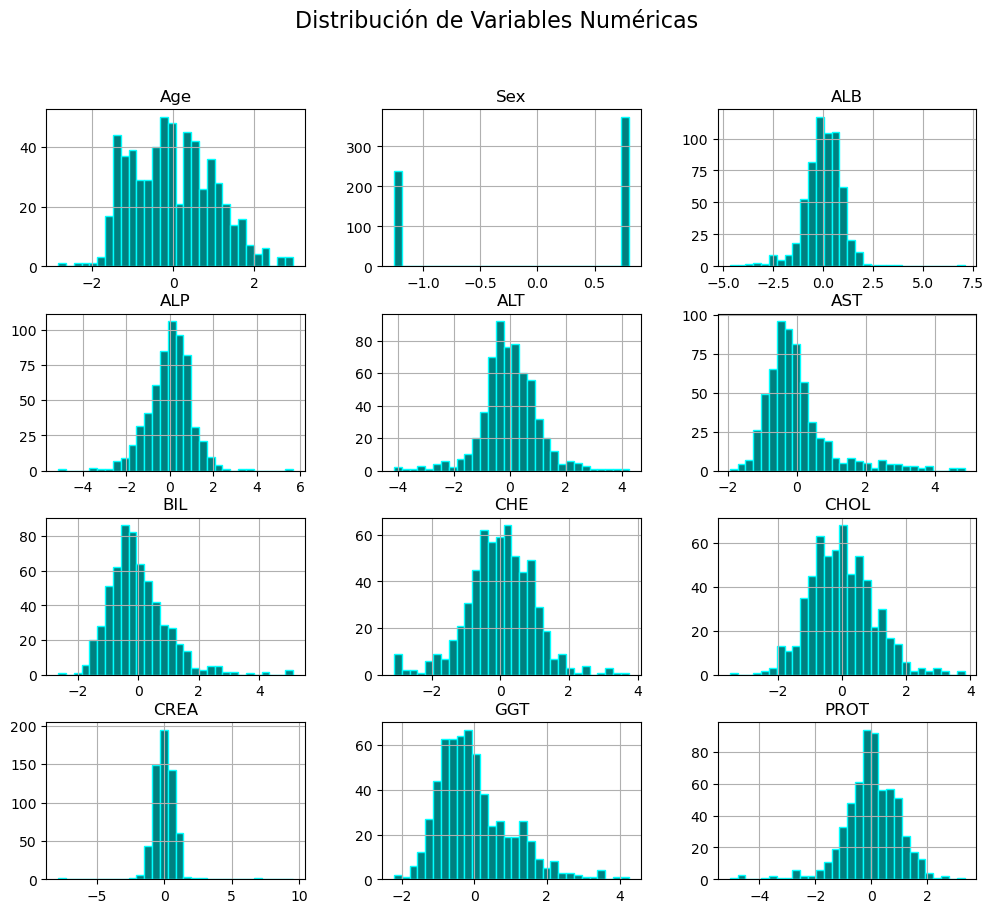

In [6]:
# Configurar el tamaño de los gráficos
plt.figure(figsize=(12, 8))

# Histograma de las variables numéricas
df.drop(columns=['target', 'suspect']).hist(figsize=(12, 10), bins=30,color='teal', edgecolor='cyan')
plt.suptitle("Distribución de Variables Numéricas", fontsize=16)
plt.show()


#### **<span style="color:purple">Análisis del Gráfico de Distribución de Variables Numéricas</span>**

- Se presentan histogramas de las variables numéricas después de la limpieza y transformación. Permiten visualizar cómo se distribuyen los datos luego de la transformación logarítmica y estandarización (Z-score).
- **Objetivo:** Analizar si los datos tienen una distribución más normalizada después del preprocesamiento.

**Observaciones Clave del Gráfico**

1. **Las variables ahora tienen una distribución más simétrica**

    - Antes de la transformación, muchas variables (especialmente ALT, AST, BIL, GGT, ALP, CREA) estaban sesgadas hacia la derecha con valores extremadamente altos.
    - Después de la normalización, la mayoría de las variables tienen una distribución aproximadamente normal (campana de Gauss). Esto facilita el entrenamiento de modelos de Machine Learning, ya que estos funcionan mejor con datos normalizados.

2. **Los valores extremos fueron ajustados sin ser eliminados**

    - Se aplicó transformación logarítmica (log1p) a variables con sesgo positivo.
    - Esta transformación reduce la dispersión de valores extremos sin perder información crítica sobre pacientes con valores elevados en biomarcadores hepáticos. Ejemplo: ALT, AST, BIL, GGT, CREA ahora tienen distribuciones más compactas y simétricas.
      
3. **Los datos ahora son comparables en escala**

    - Se aplicó estandarización (Z-score) para escalar todas las variables en una misma unidad de medida.
    - En el gráfico, todas las variables ahora están centradas alrededor de 0 con una dispersión más uniforme.
    - Esto permite que cada variable tenga el mismo peso en el modelo, evitando que variables con valores más grandes dominen la predicción.


**Conclusión Final**

- La normalización y transformación mejoraron la distribución de las variables, haciéndolas más simétricas.
- Se mantuvo la información clínica de los valores extremos en lugar de eliminarlos.
- Ahora los datos están listos para el entrenamiento de modelos de Machine Learning.

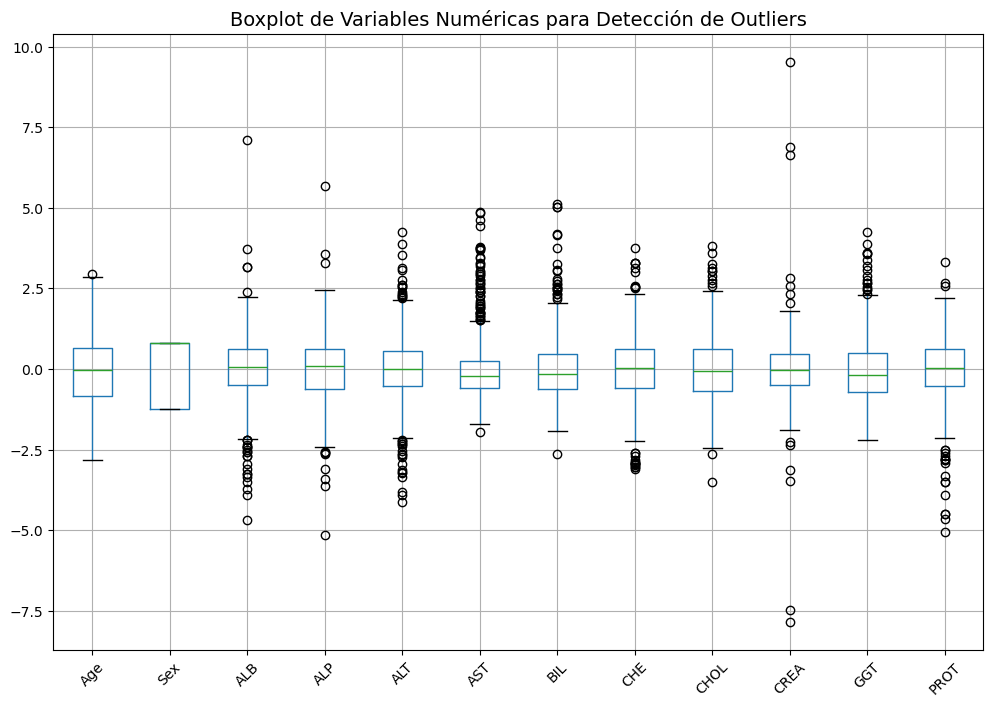

In [8]:
# Boxplots para revisar outliers
plt.figure(figsize=(12, 8))
df.drop(columns=['target', 'suspect']).boxplot(rot=45)
plt.title("Boxplot de Variables Numéricas para Detección de Outliers", fontsize=14)
plt.show()


#### **<span style="color:purple">Análisis del Boxplot de Variables Numéricas para Detección de Outliers</span>**  

- Se presentan **boxplots de todas las variables numéricas** después de la **transformación logarítmica y estandarización (Z-score)**.  
- Los **outliers (valores atípicos)** se muestran como **puntos dispersos** fuera del rango intercuartílico.  
- **Objetivo:** Evaluar cómo quedaron distribuidos los valores después del preprocesamiento y confirmar que **los valores extremos clínicamente relevantes se mantuvieron**.


**Observaciones Clave del Boxplot**  

1. **La normalización no eliminó los outliers, pero redujo su impacto**  
    - **Los valores atípicos siguen presentes**, pero ahora están mejor distribuidos dentro de los rangos esperados.  
    - La **transformación logarítmica redujo la amplitud de los valores extremos**, haciendo que el modelo los procese de manera más estable.  
    - **Ejemplo:** 'ALT', 'AST', 'BIL', 'GGT', 'ALP' y 'CREA' aún tienen valores atípicos, pero ya no dominan la escala del dataset.  

2. **Distribución más homogénea entre variables**  
    - Antes de la normalización, algunas variables tenían **escalas muy diferentes** (por ejemplo, 'ALT' y 'GGT' tenían valores en cientos mientras que 'CHOL' y 'ALB' estaban en rangos pequeños).  
    - **Ahora, todas las variables están en una escala similar**, con la mediana en torno a 0.  
    - Esto **evita que alguna variable tenga un peso excesivo en los modelos de Machine Learning**.

3. **Se mantienen valores atípicos clínicamente relevantes** 
    - No se eliminaron outliers porque **pueden representar casos reales de enfermedades hepáticas**.  
    - Estos valores **pueden ser indicadores clave para detectar pacientes con problemas hepáticos graves**.  
    - **Ejemplo:** Valores altos en 'ALT', 'AST', 'BIL', 'GGT' pueden ser signos de **hepatitis, fibrosis o cirrosis**.
      

**Conclusión Final**  
- **Los valores atípicos siguen presentes, pero ahora están mejor distribuidos.**  
- **La normalización mejoró la comparabilidad entre variables sin perder información.**  
- **Los datos están listos para el entrenamiento de modelos de Machine Learning.**  

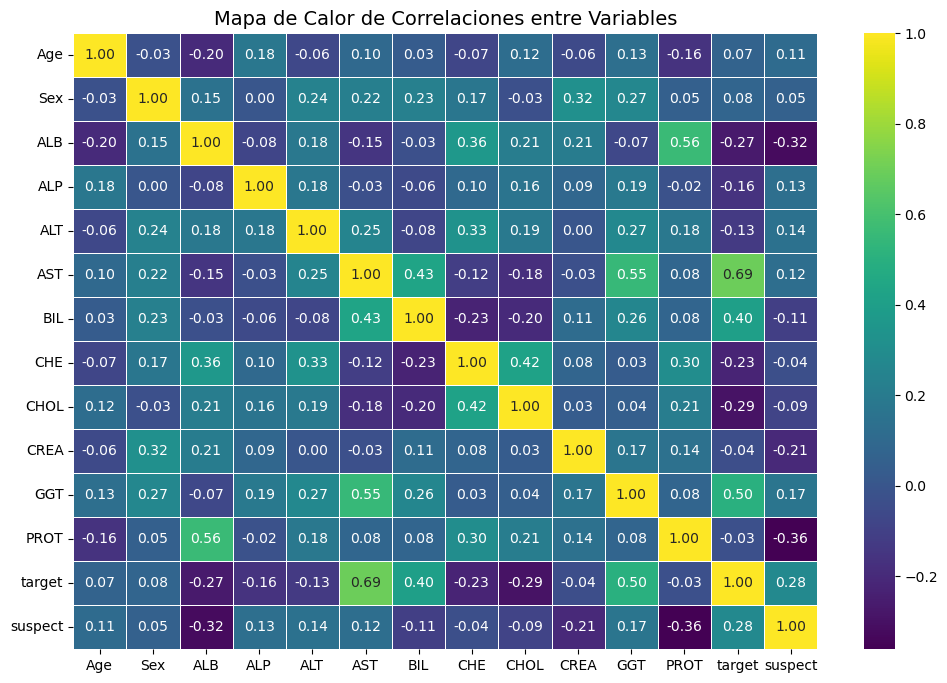

In [10]:

# Mapa de calor de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones entre Variables", fontsize=14)
plt.show()


#### **<span style="color:purple">Análisis del Mapa de Calor de Correlaciones entre Variables</span>**     

- Este **heatmap** representa la **correlación** entre las variables numéricas del dataset después de la transformación logarítmica y estandarización.  

**Observaciones Clave del Heatmap**  

1. **Variables con mayor correlación con la variable objetivo ('target')**  

    - **'AST' (0.69)** → **Fuerte correlación positiva** con **target**, lo que sugiere que valores altos de esta enzima están fuertemente asociados con la presencia de enfermedades hepáticas.  
    - **GGT (0.50)** → También muestra una **correlación moderada-alta**, lo que indica que niveles elevados pueden ser un **indicador de enfermedad hepática**. 
    - **Conclusión:** **AST y GGT** son variables clave para predecir enfermedades hepáticas.  

2. **Variables con correlaciones negativas con 'target'**

    - **ALB (-0.27)** y **CHE (-0.23)** tienen **correlaciones negativas moderadas** con 'target'.  
    - Esto indica que **niveles más bajos de albúmina y colinesterasa pueden estar asociados con enfermedades hepáticas**.  
    - **Posible explicación:** En pacientes con insuficiencia hepática, la producción de estas proteínas puede verse afectada.  
    - **Conclusión:** Niveles bajos de **ALB** y **CHE** pueden ser un indicador de enfermedad hepática. 

3. **Correlaciones entre variables hepáticas**  
    - **ALT, AST y GGT** tienen correlaciones moderadas entre sí (**entre 0.25 y 0.55**), lo que es esperado, ya que todas estas enzimas están relacionadas con la función hepática.  
    - **ALT** y **GGT** tienen **0.27**, lo que indica que pueden estar relacionadas, pero no son exactamente equivalentes.  

**Importante:** Si dos variables están fuertemente correlacionadas, podría haber **colinealidad**, lo que puede afectar la interpretación del modelo. Se podría considerar técnicas como PCA o selección de características.  

4. **Correlación con 'suspect'**  
    - **suspect** tiene una correlación de **0.28** con **target**, lo que significa que aunque existe cierta relación, no es lo suficientemente fuerte como para considerarla una variable determinante para la clasificación de enfermedades hepáticas.  
    - **Esto refuerza la decisión de NO usar *suspect* como variable objetivo**.  

---

**Conclusión**  

- **Las variables más relevantes** para la predicción de enfermedades hepáticas son **AST, GGT y ALT.**  
- **Niveles bajos de 'ALB' y 'CHE'** también pueden indicar enfermedad hepática.  
- **Se debe considerar el impacto de la colinealidad en algunas variables altamente correlacionadas.**  
- **La variable 'suspect' no es una buena candidata para predecir enfermedades hepáticas.**  

In [12]:
# 10. Segmentación en 67% entrenamiento y 33% test
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# 11. Mostrar las dimensiones de los conjuntos
print("Dimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensiones de los conjuntos de datos:
X_train: (410, 13), X_test: (202, 13)
y_train: (410,), y_test: (202,)


**<span style="color:#00008B">La división se realizó correctamente, quedando 410 muestras para entrenamiento y 202 muestras para prueba. Ahora los datos están listos para entrenar modelos de Regresión Logística y Extreme Gradient Boosting (XGBoost).</span>**

---
### **<span style="color:orange">Punto 2.- Regresión Logística con Elastic Net y Validación Cruzada (5-Fold)</span>**

**El objetivo** de este modelo es predecir si un paciente tiene una posible enfermedad hepática (target=1) o es un donante de sangre sano (target=0). Para ello, **se entrena un modelo de Regresión Logística** con regularización **Elastic Net**, que combina las penalizaciones L1 (Lasso) y L2 (Ridge). **Esto permite seleccionar características relevantes y evitar sobreajuste**.

**<span style="color:olive">Pasos del Modelo</span>**

1. **Definir Validación Cruzada (5-Fold)**
   
- Se utiliza validación cruzada estratificada (5-fold) para asegurar que en cada subdivisión los datos mantengan la proporción original de clases (target=0 y target=1). Esto evita sesgos en el entrenamiento y mejora la generalización del modelo.

2. **Definir Rango de Hiperparámetros**

- Para **optimizar** el rendimiento del modelo, se realiza una búsqueda en grilla de dos hiperparámetros clave:

  - **Cs:** Controla la fuerza de la regularización. Un valor mayor reduce la penalización, permitiendo más flexibilidad en el modelo.
  - **l1_ratio:** Define la combinación entre regularización L1 (Lasso) y L2 (Ridge). Un valor de 0 usa solo Ridge, un valor de 1 usa solo Lasso, y valores intermedios combinan ambas técnicas.
    
- Ambos hiperparámetros se exploran en un rango de 200 valores cada uno para encontrar la mejor combinación.

3. **Configurar la Regresión Logística con Elastic Net**

- Se emplea LogisticRegressionCV, una variante de regresión logística que permite la selección automática de hiperparámetros mediante validación cruzada.
- Se optimiza la métrica **F1-score**, dado que en problemas de salud es crucial equilibrar precisión y recall.

4. **Entrenar el Modelo**

- El modelo se entrena en los datos de entrenamiento (X_train, y_train). Durante este proceso, prueba todas las combinaciones de Cs y l1_ratio para encontrar la configuración óptima que maximice el desempeño.

5. **Predicción y Evaluación**

- Después del entrenamiento, el modelo realiza predicciones sobre los datos de prueba (X_test).
- Se calculan las siguientes métricas clave para evaluar el rendimiento:

    - **Accuracy:** Indica qué porcentaje de los casos fueron clasificados correctamente.
    - **Precision:** Mide cuántas de las predicciones positivas fueron realmente positivas.
    - **Recall:** Evalúa cuántos de los casos positivos reales fueron detectados correctamente.
    - **F1-score:** Calcula el equilibrio entre precisión y recall, ideal en casos donde el costo de falsos negativos es alto.

6. **Selección de los Mejores Hiperparámetros**
   
- Después del entrenamiento, el modelo devuelve los **valores óptimos de C y l1_ratio**, que representan la mejor combinación de regularización encontrada en la validación cruzada. Esto nos permite entender qué nivel de penalización y qué proporción de L1/L2 funciona mejor en la clasificación de los pacientes.

7. **Identificación de las Variables más Relevantes**
   
- Se extraen los coeficientes aprendidos por la regresión logística para determinar cuáles son las variables más influyentes en la predicción.
- Los coeficientes con valores más altos (positivos o negativos) indican qué variables tienen mayor impacto en la clasificación de los pacientes.
- Se identifican las tres características más importantes, lo que puede ayudar en la interpretación clínica del modelo.

8. **Matriz de Confusión**
   
- Para analizar con mayor detalle el desempeño del modelo, se genera una matriz de confusión, que muestra:

    - **Verdaderos Positivos (TP): Casos correctamente clasificados como target=1.**
    - **Falsos Positivos (FP): Casos incorrectamente clasificados como target=1.**
    - **Verdaderos Negativos (TN): Casos correctamente clasificados como target=0.**
    - **Falsos Negativos (FN): Casos incorrectamente clasificados como target=0.**

- Esto permite evaluar errores específicos y ajustar estrategias para mejorar la detección de enfermedades hepáticas.

**Conclusión**

- Este modelo de regresión logística con Elastic Net optimiza la clasificación de pacientes con posible enfermedad hepática.
- La validación cruzada y la optimización de hiperparámetros garantizan un modelo robusto y bien ajustado.
- Las características más relevantes permiten comprender qué factores tienen mayor incidencia en la predicción.


In [14]:
# Definir validación cruzada con 5 folds
# Estrategia de validación cruzada estratificada para asegurar que la proporción de clases se mantenga en cada fold.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el rango de hiperparámetros para la búsqueda
# 'Cs' controla la fuerza de la regularización en la regresión logística (inverso de lambda).
# 'l1_ratios' define el balance entre regularización L1 (Lasso) y L2 (Ridge).
Cs_values = np.linspace(0.01, 5.0, 200)  # 200 valores entre 0.01 y 5.0
l1_ratios = np.linspace(0, 1, 200)  # 200 valores entre 0 y 1

# Definir el modelo de Regresión Logística con Elastic Net
logreg = LogisticRegressionCV(
    Cs=Cs_values,  # Valores de regularización a probar
    cv=cv,  # Validación cruzada de 5 folds
    penalty="elasticnet",  # Se usa Elastic Net (combinación de L1 y L2)
    solver="saga",  # Solver optimizado para Elastic Net en datasets grandes
    l1_ratios=l1_ratios,  # Valores de L1 a probar
    max_iter=5000,  # Número máximo de iteraciones para converger
    random_state=42,  # Reproducibilidad de resultados
    scoring="f1",  # Optimización basada en F1-score
    n_jobs=-1)  # Usar todos los núcleos del procesador para acelerar el cálculo


# Entrenar el modelo con los datos de entrenamiento
# Se realiza la búsqueda de hiperparámetros y ajuste del modelo.
logreg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

# Evaluación del modelo con métricas clave
accuracy = accuracy_score(y_test, y_pred)  # Exactitud global
precision = precision_score(y_test, y_pred)  # Precisión (TP / (TP + FP))
recall = recall_score(y_test, y_pred)  # Sensibilidad o recall (TP / (TP + FN))
f1 = f1_score(y_test, y_pred)  # F1-score (balance entre precisión y recall)

#  Obtener los mejores hiperparámetros encontrados por validación cruzada
best_C = logreg.C_[0]  # Mejor valor de C (regularización)
best_l1_ratio = logreg.l1_ratio_[0]  # Mejor combinación de L1 y L2

# Obtener la importancia de las características a partir de los coeficientes
# En la regresión logística, los coeficientes representan la contribución de cada variable.
# Tomamos el valor absoluto para ver el impacto de cada variable, sin importar la dirección.
coef_importance = pd.Series(abs(logreg.coef_[0]), index=X_train.columns).sort_values(ascending=False)

# Mostrar resultados del modelo
print("\n**Resultados de la Regresión Logística con Elastic Net**")
print(f"- Mejor C encontrado: {best_C}")
print(f"- Mejor l1_ratio encontrado: {best_l1_ratio}")

print("\n**Métricas de Evaluación**")
print(f" - Accuracy: {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1-score: {f1:.4f}")

# Mostrar las tres características con mayor impacto en la predicción
print("\n**Top 3 Variables con Mayor Impacto en la Predicción**")
print(coef_importance.head(3))

# Matriz de confusión opcional para ver el desempeño del modelo
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n Matriz de Confusión:")
print(conf_matrix)




**Resultados de la Regresión Logística con Elastic Net**
- Mejor C encontrado: 2.4172361809045224
- Mejor l1_ratio encontrado: 0.9849246231155779

**Métricas de Evaluación**
 - Accuracy: 0.9653
 - Precision: 1.0000
 - Recall: 0.7308
 - F1-score: 0.8444

**Top 3 Variables con Mayor Impacto en la Predicción**
suspect    9.338240
GGT        2.236357
AST        2.145382
dtype: float64

 Matriz de Confusión:
[[176   0]
 [  7  19]]


#### **<span style="color:purple">Resultados del Modelo de Regresión Logística con Elastic Net</span>**  

#### **<span style="color:teal">1. Resumen de los Hiperparámetros Óptimos</span>**

- Después de realizar la búsqueda de hiperparámetros con **validación cruzada 5-fold**, los valores óptimos encontrados fueron:

    - **Mejor C** (*Fuerza de la regularización*): **2.4172**
    - **Mejor l1_ratio** (*Proporción entre L1 y L2 en Elastic Net*): **0.9849**

- Un valor alto de **l1_ratio** indica que el modelo favoreció más la regularización **Lasso (L1)**, lo que sugiere que el modelo eliminó o redujo el impacto de algunas características irrelevantes.


#### **<span style="color:teal">2. Evaluación del Modelo: Métricas Clave</span>**

| **Métrica**   | **Valor**  | **Interpretación** |
|--------------|------------|--------------------|
| **Accuracy**  | `0.9653`   | El **96.53%** de las predicciones fueron correctas. |
| **Precision** | `1.0000`   | **El modelo no tiene falsos positivos**, es decir, **no clasifica erróneamente a pacientes sanos como enfermos**. |
| **Recall**    | `0.7308`   | El **73.08% de los pacientes enfermos fueron detectados correctamente**, pero el resto fueron clasificados erróneamente como sanos (**falsos negativos**). |
| **F1-score**  | `0.8444`   | Balance entre precisión y recall. Un valor de **0.84** indica un **buen rendimiento**, pero con margen de mejora en recall. |

**Conclusión**:  
    - **El modelo tiene una alta precisión**, lo que significa que **no comete errores clasificando personas sanas como enfermas**.  
    - **Sin embargo, tiene un recall de 73.08%**, lo que indica que **algunos pacientes enfermos no son detectados correctamente**.  


#### **<span style="color:teal">3. Variables con Mayor Impacto en la Predicción</span>**

- **Las tres características con mayor influencia en la predicción del modelo fueron:**

| **Variable**  | **Valor del Coeficiente** | **Interpretación** |
|--------------|-----------------|--------------------|
| **`suspect`** | `9.3382` | Los donantes sospechosos tienen **fuerte impacto** en la clasificación. |
| **`GGT`** | `2.2363` | La enzima hepática **GGT** tiene una alta relación con enfermedades hepáticas. |
| **`AST`** | `2.1453` | **AST** es otro marcador hepático importante en la predicción de enfermedades. |

**Conclusión**:  
    - La característica **más relevante** en la clasificación es si el paciente es un **donante sospechoso ('suspect')**.  
    - Los marcadores hepáticos **GGT y AST** también juegan un papel clave en la detección de enfermedades hepáticas.  


#### **<span style="color:teal">4. Análisis de la Matriz de Confusión</span>**

**<span style="color:navy">Matriz de Confusión: [[176 0] [ 7 19]]</span>**

**Interpretación:**  
    - **176 casos verdaderamente negativos** (donantes sanos correctamente clasificados).  
    - **19 casos verdaderamente positivos** (pacientes con enfermedad correctamente clasificados).  
    - **7 casos falsos negativos** (pacientes con enfermedad **clasificados erróneamente como sanos**).  
    - **0 casos falsos positivos** (ningún donante sano fue clasificado erróneamente como enfermo).  

**Conclusión:**  
    - **El modelo tiene una gran precisión**, ya que **no comete errores clasificando donantes sanos como enfermos**.  
    - **Sin embargo, tiene algunos falsos negativos**, lo que significa que algunos **pacientes enfermos fueron diagnosticados como sanos**.  


#### **<span style="color:teal">5. Conclusiones</span>**

- **Modelo con alta precisión (1.0000)**, ideal cuando el objetivo es evitar falsos positivos.  
- **El recall es moderado (0.7308), por lo que aún hay pacientes enfermos no detectados**.
- **Variables más importantes:** **'suspect', 'GGT', 'AST'**, todos relacionados con la salud hepática.  
- **Posibles mejoras:** Ajustar **peso de clases** en el modelo para mejorar recall.  

---
---

### **<span style="color:orange">Punto 3.- Extreme Gradient Boosting (XGBoost) con Búsqueda de Hiperparámetros</span>**

El objetivo de este modelo es **predecir si un paciente tiene una posible enfermedad hepática ('target=1') o es un donante sano ('target=0')**. Para esto, se implementa un **modelo de Extreme Gradient Boosting (XGBoost)**, una técnica avanzada de árboles de decisión que optimiza la predicción mediante boosting.  

En este caso, optimizamos los hiperparámetros para mejorar el rendimiento del modelo y evitar sobreajuste.


#### **<span style="color:teal">Configuración de la Búsqueda de Hiperparámetros</span>**

Para encontrar la mejor combinación de hiperparámetros, realizamos una **búsqueda en grilla (Grid Search) o aleatoria (Randomized Search) con validación cruzada**. Se ajustan los siguientes parámetros clave:

- **'reg_lambda' (Regularización L2 - Ridge)**: Controla la penalización sobre los coeficientes para evitar sobreajuste.
- **'reg_alpha' (Regularización L1 - Lasso)**: Realiza selección de características al penalizar coeficientes pequeños.
- **'learning_rate' (Tasa de aprendizaje)**: Controla la magnitud de cada actualización de peso en los árboles de decisión.

Cada hiperparámetro se explora en los siguientes rangos:
- **'reg_lambda'**: Se prueban **10 valores lineales entre 0.0 y 2.0**.
- **'reg_alpha'**: Se prueban **10 valores lineales entre 0 y 1**.
- **'learning_rate'**: Se prueban **20 valores lineales entre 0.1 y 10**.


#### **<span style="color:teal">Implementación del Modelo XGBoost</span>**

1. **Se define el modelo base 'XGBClassifier'**, configurado para clasificación binaria con **objective="binary:logistic**.  
2. **Se realiza la búsqueda de hiperparámetros ('GridSearchCV' o 'RandomizedSearchCV')** para optimizar los valores de **reg_lambda**, **reg_alpha** y **learning_rate**.  
3. **Se usa validación cruzada con 5 folds ('cv=5')** para garantizar que el modelo generalice bien nuevos datos.  
4. **Se entrena el modelo con el conjunto de entrenamiento ('X_train', 'y_train')**, explorando diferentes combinaciones de hiperparámetros.  
5. **Se selecciona el mejor modelo** basado en la métrica **F1-score**, que balancea precisión y recall.  
5. **Se evalúa el modelo en el conjunto de prueba ('X_test')**, obteniendo las métricas de rendimiento:  
   - **Accuracy**: Porcentaje total de predicciones correctas.  
   - **Precision**: Qué porcentaje de los casos predichos como positivos realmente lo son.  
   - **Recall**: Qué porcentaje de los casos positivos reales fueron detectados.  
   - **F1-score**: Equilibrio entre precisión y recall.  

---

**XGBoost es un modelo potente que combina árboles de decisión y boosting para mejorar la precisión.**  
**La optimización de hiperparámetros ayuda a encontrar la mejor combinación para mejorar el rendimiento.**  
**Los resultados obtenidos se compararán con los de la regresión logística para evaluar cuál modelo es más efectivo.**  

In [31]:
# Definir los hiperparámetros a optimizar en la búsqueda en grilla
param_grid = {
    'reg_lambda': np.linspace(0.0, 2.0, 10),  # Regularización L2 (Ridge) para controlar la complejidad del modelo
    'reg_alpha': np.linspace(0, 1, 10),       # Regularización L1 (Lasso) para reducir la influencia de características irrelevantes
    'learning_rate': np.linspace(0.1, 10, 20)} # Tasa de aprendizaje: controla qué tan rápido aprende el modelo


# Definir el modelo base de XGBoost (sin optimización aún)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Modelo de clasificación binaria (0 o 1)
    eval_metric='logloss',  # Se usa log-loss como métrica de evaluación
    random_state=42,  # Asegura reproducibilidad en los resultados
    n_estimators=100)  # Número de árboles en el bosque de decisión


# Configurar la búsqueda de hiperparámetros con validación cruzada de 5 folds
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,  # Modelo base de XGBoost
    param_grid=param_grid,  # Hiperparámetros a optimizar
    scoring='f1',  # Optimización basada en el F1-score (mejor métrica para datos desbalanceados)
    cv=5,  # Validación cruzada con 5 particiones (folds)
    verbose=1,  # Imprime el progreso del entrenamiento
    n_jobs=-1)  # Usa todos los núcleos disponibles para acelerar el proceso


# Entrenar el modelo con la búsqueda de hiperparámetros
# GridSearchCV probará todas las combinaciones de hiperparámetros y elegirá la mejor
grid_search_xgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados en la búsqueda
best_params_xgb = grid_search_xgb.best_params_  # Guarda la mejor combinación de hiperparámetros

# Evaluar el mejor modelo encontrado en el conjunto de prueba
best_xgb = grid_search_xgb.best_estimator_  # Extrae el mejor modelo entrenado
y_pred_xgb = best_xgb.predict(X_test)  # Realiza predicciones en los datos de prueba

# Calcular métricas de evaluación para medir el rendimiento del modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)  # Porcentaje de predicciones correctas
precision_xgb = precision_score(y_test, y_pred_xgb)  # Proporción de verdaderos positivos sobre los predichos como positivos
recall_xgb = recall_score(y_test, y_pred_xgb)  # Capacidad del modelo para encontrar casos positivos
f1_xgb = f1_score(y_test, y_pred_xgb)  # Media armónica entre precisión y recall (mejor métrica para clases desbalanceadas)

# Mostrar los resultados obtenidos
print("\n**Mejores Hiperparámetros Encontrados:**")
print(best_params_xgb)  # Muestra la mejor configuración de hiperparámetros

print("\n**Métricas de Evaluación - XGBoost:**")
print(f" - Accuracy: {accuracy_xgb:.4f}")  # Muestra la precisión del modelo
print(f" - Precision: {precision_xgb:.4f}")  # Muestra la precisión de la clase positiva
print(f" - Recall: {recall_xgb:.4f}")  # Muestra la tasa de verdaderos positivos
print(f" - F1-score: {f1_xgb:.4f}")  # F1-score, métrica más importante en clasificación binaria desbalanceada


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits

**Mejores Hiperparámetros Encontrados:**
{'learning_rate': 1.142105263157895, 'reg_alpha': 0.0, 'reg_lambda': 0.8888888888888888}

**Métricas de Evaluación - XGBoost:**
 - Accuracy: 0.9752
 - Precision: 0.9565
 - Recall: 0.8462
 - F1-score: 0.8980


#### **<span style="color:purple">Resultados del Modelo XGBoost con Búsqueda de Hiperparámetros</span>**  

#### **<span style="color:teal">1. Optimización de Hiperparámetros</span>**

- Después de realizar la búsqueda en grilla con **validación cruzada 5-fold**, se encontraron los siguientes **mejores hiperparámetros**:

| **Hiperparámetro**   | **Valor Óptimo Encontrado** | **Descripción** |
|----------------------|----------------------------|----------------|
| **`learning_rate`** | `1.1421`  | Tasa de aprendizaje óptima. Un valor alto indica que el modelo ajusta más rápido. |
| **`reg_alpha`**     | `0.0`     | No se aplicó regularización L1 (Lasso). |
| **`reg_lambda`**    | `0.8889`  | Regularización L2 (Ridge), ayuda a evitar sobreajuste. |

**Interpretación:**  
    - **El modelo encontró un 'learning_rate' relativamente alto (1.1421)**, lo que puede indicar que los datos permiten ajustes más rápidos sin comprometer la estabilidad del modelo.  
    - **No se aplicó regularización L1 ('reg_alpha = 0.0')**, lo que sugiere que todas las características fueron útiles para la predicción y no hubo necesidad de eliminar características irrelevantes.  
    - **Se aplicó una regularización moderada L2 ('reg_lambda = 0.8889')**, lo que ayuda a evitar sobreajuste sin restringir demasiado los coeficientes del modelo.  


#### **<span style="color:teal">2. Evaluación del Modelo: Métricas Clave</span>**

| **Métrica**   | **Valor**  | **Interpretación** |
|--------------|------------|--------------------|
| **Accuracy**  | `0.9752`   | El **97.52%** de las predicciones fueron correctas. |
| **Precision** | `0.9565`   | El modelo clasificó correctamente el **95.65%** de los pacientes predichos como enfermos. |
| **Recall**    | `0.8462`   | El **84.62% de los pacientes enfermos fueron detectados correctamente**. |
| **F1-score**  | `0.8980`   | Balance entre precisión y recall, con un valor **mayor que el modelo de regresión logística**. |

**Conclusión:**  
    - **El modelo tiene una precisión muy alta (0.9565), lo que indica que la mayoría de las predicciones de "enfermo" son correctas.**  
    - **El recall es de 0.8462, lo que significa que detecta más pacientes enfermos que el modelo de regresión logística (que tenía recall = 0.7308).**
    - **El F1-score de 0.8980 muestra un buen balance entre precisión y recall.**  

---

#### **<span style="color:teal">Comparación con la regresión logística</span>**

- XGBoost tiene **mejor recall** ('0.8462' vs. '0.7308'), lo que significa que **detecta más pacientes enfermos correctamente**.  
- XGBoost mantiene una **buena precisión ('0.9565')**, aunque la regresión logística tenía un valor más alto (**'1.0000'**).  
- **El F1-score de XGBoost ('0.8980') es superior al de la regresión logística ('0.8444')**, lo que indica un mejor equilibrio entre recall y precisión.  


#### **<span style="color:teal">Conclusión</span>**

- **XGBoost supera a la Regresión Logística en Recall y F1-score**, lo que lo convierte en **un mejor modelo para detectar pacientes enfermos**.  
- **El modelo logra una precisión alta ('0.9565'), pero sin comprometer el recall**.  
- **Los hiperparámetros optimizados sugieren que el modelo se ajusta bien a los datos sin necesidad de regularización L1.**  

---
---

### **<span style="color:orange">Punto 4.- Comparación de Modelos: Regresión Logística vs XGBoost</span>**

En este paso, evaluamos el rendimiento de dos modelos de clasificación binaria:  

**Regresión Logística con Elastic Net**  
**Extreme Gradient Boosting (XGBoost)**  

El propósito es identificar **cuál modelo predice mejor la presencia de una posible enfermedad hepática** y **qué características tienen mayor impacto en la predicción**.  

---

#### **<span style="color:teal">Comparación de Hiperparámetros Óptimos</span>**

-Se imprimen los mejores valores de hiperparámetros encontrados mediante validación cruzada para ambos modelos:  
    - **Regresión Logística:** **'C'** (control de regularización) y **'l1_ratio'** (peso entre Lasso y Ridge).  
    - **XGBoost:** **'reg_lambda', 'reg_alpha' y 'learning_rate'**, que afectan la regularización y la velocidad de aprendizaje.  


#### **<span style="color:teal">Evaluación de Métricas de Rendimiento</span>**

- Se comparan los resultados de ambos modelos en el conjunto de prueba ('X_test', 'y_test') utilizando las siguientes métricas:  
    - **Accuracy**
    - **Precision**
    - **Recall**
    - **F1-score**

- Esta comparación nos permite identificar **cuál modelo se desempeña mejor en términos de clasificación**.  


#### **<span style="color:teal">Importancia de las Características en XGBoost</span>**

- Se extraen los **coeficientes de importancia** de las variables en XGBoost para entender qué factores son más relevantes en la predicción.  
    - Se ordenan las variables de mayor a menor impacto.  
    - Se visualizan las **10 características más importantes** en un gráfico de barras.  

- Esto nos permite **interpretar el modelo y validar su utilidad clínica**.  



**Valores óptimos de hiperparámetros:**
Regresión Logística -> Mejor C: 2.4172361809045224, Mejor l1_ratio: 0.9849246231155779
XGBoost -> {'learning_rate': 1.142105263157895, 'reg_alpha': 0.0, 'reg_lambda': 0.8888888888888888}

**Comparación de Métricas entre Modelos:**
Métrica        Regresión Logística XGBoost
--------------------------------------------------
Accuracy        0.9653        0.9752
Precision       1.0000        0.9565
Recall          0.7308        0.8462
F1-score        0.8444        0.8980


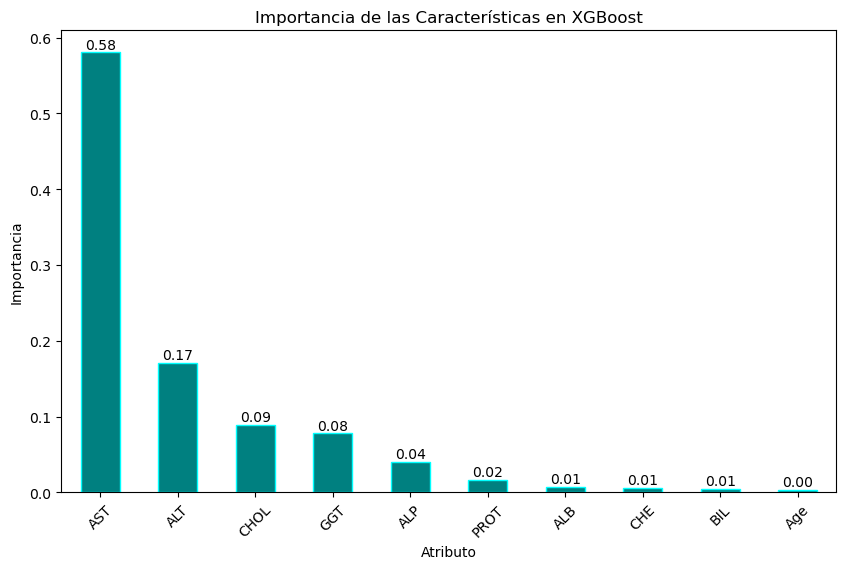


**Análisis de Resultados:**
XGBoost tiene mejor rendimiento que la Regresión Logística en términos de F1-score.

**Top 3 Variables con Mayor Impacto en XGBoost:**
AST     0.580411
ALT     0.170730
CHOL    0.088753
dtype: float32


In [57]:
# Obtener la importancia de las características en XGBoost
feature_importance = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Mostrar los valores óptimos de hiperparámetros para ambos modelos
print("\n**Valores óptimos de hiperparámetros:**")
print(f"Regresión Logística -> Mejor C: {best_C}, Mejor l1_ratio: {best_l1_ratio}")
print(f"XGBoost -> {best_params_xgb}")

# Comparar las métricas de evaluación de ambos modelos
print("\n**Comparación de Métricas entre Modelos:**")
print(f"{'Métrica':<15}{'Regresión Logística':<20}{'XGBoost'}")
print(f"{'-'*50}")
print(f"Accuracy        {accuracy:.4f}        {accuracy_xgb:.4f}")
print(f"Precision       {precision:.4f}        {precision_xgb:.4f}")
print(f"Recall          {recall:.4f}        {recall_xgb:.4f}")
print(f"F1-score        {f1:.4f}        {f1_xgb:.4f}")

# Mostrar la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='bar', color='teal', edgecolor='cyan')
plt.title("Importancia de las Características en XGBoost")
plt.xlabel("Atributo")
plt.ylabel("Importancia")
plt.xticks(rotation=45)

# Agregar etiquetas en cada barra con su valor
for i, v in enumerate(feature_importance.head(10)):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

# **Análisis de los resultados**
print("\n**Análisis de Resultados:**")
if f1_xgb > f1:
    print("XGBoost tiene mejor rendimiento que la Regresión Logística en términos de F1-score.")
else:
    print("La Regresión Logística tiene un mejor balance entre precisión y recall.")

print("\n**Top 3 Variables con Mayor Impacto en XGBoost:**")
print(feature_importance.head(3))


#### **<span style="color:purple">Análisis de la comparación entre modelos</span>**  

#### **<span style="color:teal">1. Valores Óptimos de Hiperparámetros</span>**

Se han optimizado los hiperparámetros para **Regresión Logística con Elastic Net** y **XGBoost**, obteniendo los siguientes valores óptimos:

| **Modelo**                 | **Parámetro**         | **Valor Óptimo**     |
|----------------------------|----------------------|----------------------|
| **Regresión Logística**    | `C`                  | `2.4172`             |
|                            | `l1_ratio`           | `0.9849`             |
| **XGBoost**               | `learning_rate`      | `1.1421`             |
|                            | `reg_alpha` (L1)     | `0.0`                |
|                            | `reg_lambda` (L2)    | `0.8889`             |


**<span style="color:olive">Interpretación de los Hiperparámetros</span>**

- **Regresión Logística**:  
  - **'C = 2.4172'** indica que el modelo penaliza menos los coeficientes, lo que puede aumentar la complejidad.
  - **'l1_ratio = 0.9849'** indica que el modelo favorece una regularización **casi completamente L1 (Lasso)**, lo que sugiere que algunas variables pueden haberse eliminado.
  
- **XGBoost**:  
  - **'learning_rate = 1.1421'** es relativamente alto, lo que sugiere que el modelo converge rápidamente.  
  - **'reg_alpha = 0.0'** indica que no se aplicó regularización L1, lo que significa que no se eliminaron características.  
  - **'reg_lambda = 0.8889'** indica que se aplicó una **regularización moderada L2**, lo que previene el sobreajuste sin restringir demasiado los coeficientes.  


#### **<span style="color:teal">2. Comparación de Métricas entre Modelos</span>**

Las métricas de evaluación muestran el rendimiento de ambos modelos:

| **Métrica**   | **Regresión Logística** | **XGBoost** | **Mejor Modelo** |
|--------------|------------------------|------------|------------------|
| **Accuracy**  | `0.9653`                | `0.9752`   | 🔹 **XGBoost** (Mayor precisión global) |
| **Precision** | `1.0000`                | `0.9565`   | 🔹 **Regresión Logística** (Menos falsos positivos) |
| **Recall**    | `0.7308`                | `0.8462`   | 🔹 **XGBoost** (Mejor detección de enfermos) |
| **F1-score**  | `0.8444`                | `0.8980`   | 🔹 **XGBoost** (Mejor balance entre recall y precisión) |


**Conclusión**:

- **XGBoost tiene mejor *'Accuracy'* ('0.9752' vs. '0.9653')**, lo que indica que en general predice mejor.  
- **La Regresión Logística tiene mayor *'Precision'* ('1.0000' vs. '0.9565')**, lo que significa que cuando predice "enfermo", es más preciso.  
- **XGBoost tiene un *recall* más alto ('0.8462' vs. '0.7308')**, lo que significa que detecta más casos de enfermedad correctamente.  
- **El *'F1-score* de XGBoost ('0.8980') es superior al de la Regresión Logística ('0.8444'), lo que indica un mejor balance entre precisión y recall.**  

**<span style="color:olive">Consideraciones</span>**

- **Si se quiere evitar falsos positivos (erróneamente clasificar a alguien como enfermo), la Regresión Logística sería mejor.**  
- **Si se quiere detectar la mayor cantidad de pacientes enfermos sin importar algunos falsos positivos, XGBoost es la mejor opción.**  


#### **<span style="color:teal">3. Importancia de las Características en XGBoost</span>**

El modelo XGBoost ha identificado las variables más importantes para la predicción de enfermedad:

| **Variable** | **Importancia** | **Interpretación** |
|-------------|----------------|--------------------|
| **AST**     | `0.5804`        | Enzima hepática, **fuertemente asociada** a enfermedades del hígado. |
| **ALT**     | `0.1707`        | Indicador de daño hepático. |
| **CHOL**    | `0.0887`        | Niveles de colesterol, pueden estar relacionados con problemas metabólicos. |

**Interpretación**:
    - **AST es la característica más importante con un peso de '0.5804'**, lo que sugiere que es el principal indicador de enfermedad hepática en el modelo.  
    - **ALT también es relevante ('0.1707'), lo que respalda que ambas enzimas hepáticas son clave en la detección.**  
    - **CHOL ('0.0887') también juega un papel, aunque menor, lo que sugiere que niveles anormales pueden estar asociados a la condición de los pacientes.**  

---

#### **<span style="color:purple">Conclusión Final</span>** 

- **XGBoost superó a la Regresión Logística en *Recall* y *F1-score*, lo que lo hace un mejor modelo para identificar pacientes enfermos.**  
- **AST y ALT son las características más relevantes en ambos modelos, indicando su fuerte relación con enfermedades hepáticas.**  
- **Si el objetivo es minimizar falsos positivos, la Regresión Logística es mejor. Pero si se busca maximizar la detección de enfermos, XGBoost es la mejor opción.**  

#### **<span style="color:teal">Recomendaciones Finales</span>**

1. **Evaluar la posibilidad de ajustar aún más el *'learning_rate'* de XGBoost** para ver si un valor menor mejora la estabilidad.  
2. **Probar aumentar *'reg_alpha'* en XGBoost** para evaluar si aplicar L1 mejora el rendimiento.  
3. **Incluir más datos clínicos si están disponibles**, especialmente relacionados con *AST* y *ALT*, ya que son las variables más relevantes.  
